# PCA - Classifying Particles
This project explores Principle Component Analysis (PCA) through classifying particles into gammes or hadrons. As the features are correlated, PCA will be necessary to get a new set of features, and select the features with the most information. 

This project is based on Codecademy's [PCA Project](https://www.codecademy.com/paths/fe-path-feature-engineering/tracks/fe-feature-engineering-reducing-dimensionality/modules/fe-principal-component-analysis-pca/projects/fe-pca-project). 

## Dataset
The dataset, `telescopes.csv` was generated as desrcibed in `D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, Forschungszentrum Karlsruhe FZKA 6019 (1998)`. 

## Set Up
Import libraries and load in data.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('telescopes.csv', index_col=0)
df.dropna() # remove na values

df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


## Feature Preparation and Analysis
Extract features and labels, and analyze the features. 

In [7]:
classes = df["class"] # labels
data_matrix = df.drop(columns=["class"]) # features

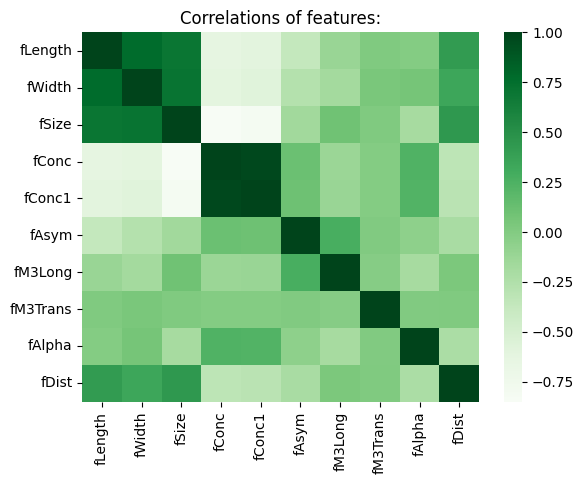

In [9]:
# get and plot feature correlations
correlation_matrix = data_matrix.corr()

ax = plt.axes()
sns.heatmap(correlation_matrix, cmap='Greens', ax=ax)
ax.set_title('Correlations of features:')
plt.show()

Ideally, features would be uncorrelated to prevent redundancy, reduce complexity, and avoid multicollinearity. Feature pairs like fLength-fWidth, fConc-fSize, and fSize-fLength are examples of features with high correlations (both positive and negative).

### Eigendecomposition
By performing eigendecomposition, we can find out the relative importance of each feature through the eigenvalues.

In [10]:
# perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
print(f'Eigenvalues length: {eigenvalues.size}, Original Number of Features: {data_matrix.shape[1]}')

Eigenvalues length: 10, Original Number of Features: 10


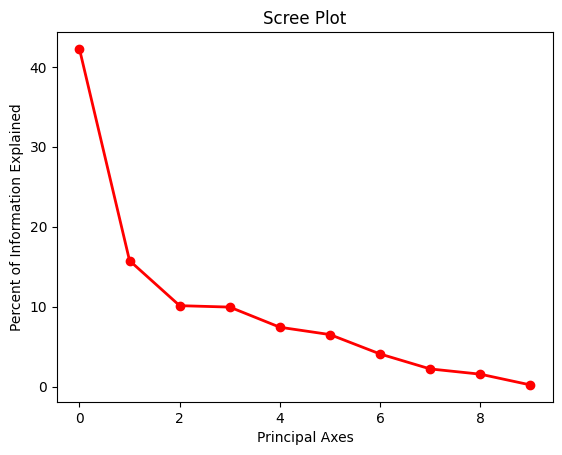

In [17]:
# order the eigenvalues from greatest to smallest
indices = eigenvalues.argsort()[::-1]  
eigenvalues = eigenvalues[indices]
eigenvectors = eigenvectors[:, indices]

# find the variance/information percentages of each eigenvalue
information_proportions = eigenvalues / eigenvalues.sum()
information_percents = information_proportions * 100

# plot the information proportions
plt.figure()
plt.plot(information_percents, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Axes')
plt.ylabel('Percent of Information Explained')
plt.show()

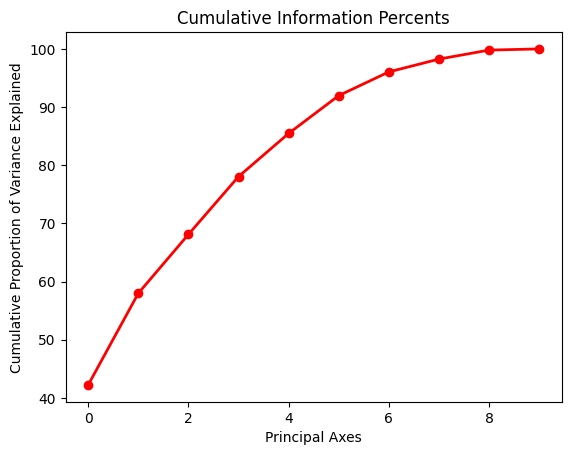

In [20]:
# find the cumulative variance/information percentage for each eigenvalue
cumulative_information_percents = np.cumsum(information_percents)

# plot the above
plt.figure()
plt.plot(cumulative_information_percents, 'ro-', linewidth=2)
plt.xlabel('Principal Axes')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title("Cumulative Information Percents")
plt.show()

## Exploring PCA (7 Components)
The PCA process is first explored with 7 components.

In [22]:
# calculate the standardized data matrix
mean = data_matrix.mean(axis=0)
sttd = data_matrix.std(axis=0)
data_matrix_standardized = (data_matrix - mean) / sttd

# perform PCA by fitting and transforming the standardized data matrix
pca = PCA(n_components=7)
principal_components = pca.fit_transform(data_matrix_standardized)
print(f'Number of features in the data matrix: {principal_components.shape[1]}')
print(f'Number of features in the principal components: {data_matrix.shape[1]}')

Number of features in the data matrix: 7
Number of features in the principal components: 10


In [23]:
# calculate eigenvalues from the singular values
singular_values = pca.singular_values_
eigenvalues = singular_values ** 2

# extract eigenvectors
eigenvectors = pca.components_.T

# extract the variance ratios (equivalent to the eigenvalue proportions from above)
principal_axes_variance_ratios = pca.explained_variance_ratio_
principal_axes_variance_percents = principal_axes_variance_ratios * 100

## Performing PCA (2 Components)

In [24]:
# perform PCA by fitting and transforming the standardized data matrix
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_matrix_standardized)
print(f'Number of Principal Components Features: {principal_components.shape[1]}')
print(f'Number of Original Data Features: {data_matrix_standardized.shape[1]}')

Number of Principal Components Features: 2
Number of Original Data Features: 10


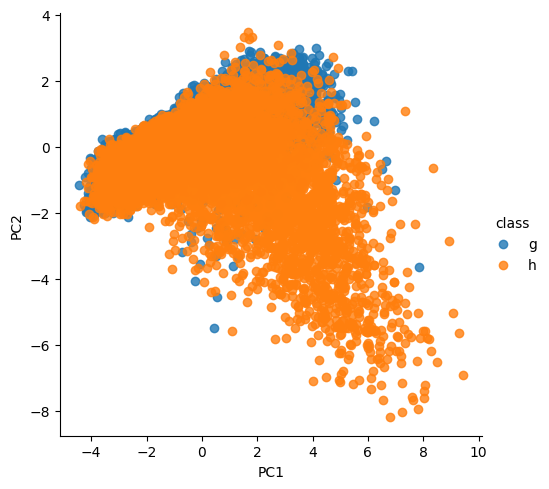

In [26]:
# plot the principle components as a scatter plot, coloured by the class
principal_components_data = pd.DataFrame({'PC1': principal_components[:, 0], 'PC2': principal_components[:, 1], 'class': classes})

sns.lmplot(x='PC1', y='PC2', data=principal_components_data, hue='class', fit_reg=False)
plt.show()

## Train Support Vector Classifier with PCA Components
A linear SVC will be fit with both the 2 PCA components, and the first two features of the original data matrix - the test scores will be used to compare the 2 models. 

In [27]:
## WITH PCA

# get features
y = classes.astype('category').cat.codes # use one-hot encoding
X = pca.fit_transform(data_matrix_standardized) 

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# create and evaluate linear SVC
svc_pca = LinearSVC(random_state=0, tol=1e-5)
svc_pca.fit(X_train, y_train) 
score_pca = svc_pca.score(X_test, y_test)
print(f'Score for model with 2 PCA features: {score_pca}')

Score for model with 2 PCA features: 0.7417556157400031


In [29]:
## WITH ORIGINAL FEATURES

# get features 
X_original = data_matrix_standardized.iloc[:, [0, 1]]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size=0.33, random_state=42)

# create and evaluate linear SVC
svc_orig = LinearSVC(random_state=0)
svc_orig.fit(X_train, y_train)
score_orig = svc_orig.score(X_test, y_test)
print(f'Score for model with 2 original features: {score_orig}')

Score for model with 2 original features: 0.7192926557272582
